# A guassian model of a single variable

Based on part of McElreath 4th book chapter.

The data are a partial census data for the Dobe area !Kung San, reference 64 in the book.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as ss

%matplotlib inline

In [2]:
# Heights from individuals older than 18
h = pd.read_csv('data/Howell1.csv', sep=';').query("age >= 18")['height']

## Likelihood and priors

$$\begin{array}{l r}
h_i \thicksim \mathrm{Normal}(\mu,\, \sigma) & [likelihood] \\
\mu \thicksim \mathrm{Normal}(150,\, 20) & [\mu \, prior] \\
\sigma \thicksim \mathrm{Uniform}(0, 50) & [\sigma\, prior]
\end{array}$$

## Bayes to get the posterior

$$Pr(\mu,\sigma|h) = \frac{
    \Pi_i\mathrm{Normal}(h_i|\mu,\, \sigma) \cdot \mathrm{Normal}(175,\, 20) \cdot \mathrm{Uniform}(0, 50)}
    {\int \int \Pi_i\mathrm{Normal}(h_i|\mu,\, \sigma) \cdot \mathrm{Normal}(175,\, 20) \cdot \mathrm{Uniform}(0, 50)}$$

## Priors

In [3]:
# prior mu is Normal
prior_mu_loc = 175  # cm
prior_mu_scale = 20
# prior s is uniform
prior_s_loc = 0
prior_s_scale = 50  # cm
# for ploting priors
prior_x4mu = np.linspace(50, 300, 100)
prior_x4s = np.linspace(-10, 60, 100)

# Sampling the priors
n_samples = 10000
sample_mu = ss.norm.rvs(loc=prior_mu_loc, scale=prior_mu_scale, size=n_samples)
sample_s = ss.uniform.rvs(loc=prior_s_loc, scale=prior_s_scale, size=n_samples)
prior_h = ss.norm.rvs(loc=sample_mu, scale=sample_s)

# Fitting a normal distribution to the data
mu_fit, std_fit = ss.norm.fit(prior_h)

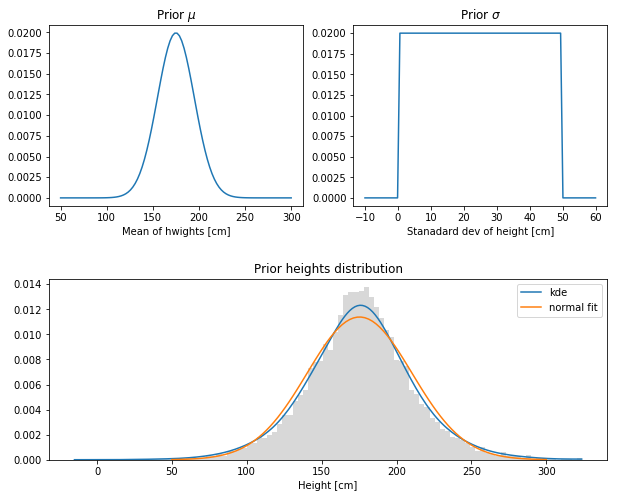

In [4]:
fig = plt.figure(figsize=(10, 8))
gs = mpl.gridspec.GridSpec(2, 2)
ax00 = fig.add_subplot(gs[0, 0])
ax00.plot(prior_x4mu, ss.norm.pdf(prior_x4mu, prior_mu_loc, prior_mu_scale))
ax00.set_title('Prior $\mu$')
ax00.set_xlabel('Mean of hwights [cm]')
ax01 = fig.add_subplot(gs[0, 1])
ax01.plot(prior_x4s, ss.uniform.pdf(prior_x4s, loc=prior_s_loc, scale=prior_s_scale))
ax01.set_title('Prior $\sigma$')
ax01.set_xlabel('Stanadard dev of height [cm]')
ax1 = fig.add_subplot(gs[1, :])
ax1.hist(prior_h, bins=100, density=True, color='grey', alpha=0.3)
pm.kdeplot(prior_h, ax=ax1, label='kde')
ax1.plot(prior_x4mu, ss.norm.pdf(prior_x4mu, loc=mu_fit, scale=std_fit),
    label='normal fit')
ax1.legend()
ax1.set_title('Prior heights distribution')
ax1.set_xlabel('Height [cm]')
fig.subplots_adjust(hspace=0.4);

## Grid approximation of the posterior distribution

In [5]:
# create combinations of mu and s
# NOTE. I don't get the rationale for choosing these grid min, max and step. But, apart from this example,
# a MCMC will be used instead of a grid approximation.

grid_df = pd.DataFrame(
    np.mgrid[
        (int(h.mean()) - 10):(int(h.mean()) + 10):0.1,
        (int(h.std()) - 2):(int(h.std()) + 2):0.02
    ].reshape(2, -1).T, columns=['mu', 's']
)

# Calculate the log-likelihood.
# NOTE operating in log space helps to avoid rounding errors that arise when
# one multiplies many small probabilities.
# NOTE that the log-likelihood of the observations are summed, that is their
# likelihood probabilities are multiplied.
# NOTE we are calculating the (log) probability of observing each observation
# if it would come from a normal distributiond with the mu and std in the grid.
grid_df = grid_df.assign(
    loglikelihood=grid_df.apply(
        lambda row: ss.norm.logpdf(h, loc=row['mu'], scale=row['s']).sum(),
        axis=1
))

# log_posterior probability distribution
grid_df = grid_df.assign(
    log_posterior=(
        grid_df['loglikelihood'] +
        ss.norm.logpdf(grid_df['mu'], loc=prior_mu_loc, scale=prior_mu_scale) +
        ss.uniform.logpdf(grid_df['s'], loc=prior_s_loc, scale=prior_s_scale)
    )
)
# Calculating relative probabilities from log-probabilities, using a trick to
# circumvent rounding errors (McElreath)
grid_df = grid_df.assign(
    posterior=np.exp(grid_df['log_posterior'] - grid_df['log_posterior'].max())
)

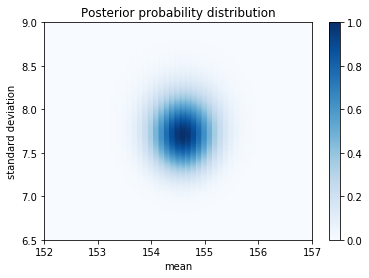

In [6]:
# Posterior probability distribution
sc = plt.scatter(grid_df['mu'], grid_df['s'], c=grid_df['posterior'],
    cmap='Blues')
plt.xlim(152, 157)
plt.ylim(6.5, 9)
plt.xlabel('mean')
plt.ylabel('standard deviation')
plt.title('Posterior probability distribution')
plt.colorbar(sc);

## Sampling the posterior probability distribution

In [7]:
sample_grid = grid_df.sample(n=int(1e4), replace=True, weights='posterior')

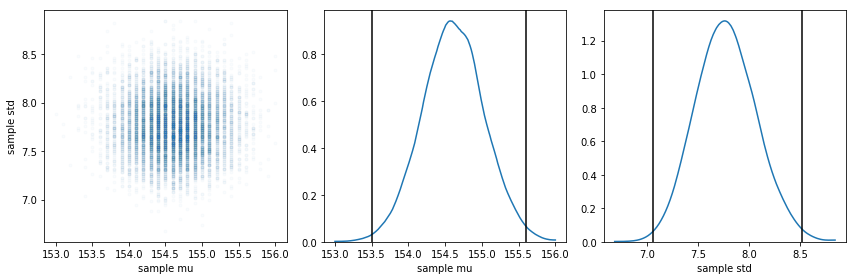

In [8]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
ax[0].scatter(sample_grid['mu'], sample_grid['s'], alpha=0.02, marker='.')
ax[0].set_xlabel('sample mu')
ax[0].set_ylabel('sample std')
pm.kdeplot(sample_grid['mu'], ax=ax[1])
# High posterior density intervals
for l in pm.hpd(sample_grid['mu'], 0.01):
    ax[1].axvline(l, c='k')
ax[1].set_xlabel('sample mu')
pm.kdeplot(sample_grid['s'], ax=ax[2])
for l in pm.hpd(sample_grid['s'], 0.01):
    ax[2].axvline(l, c='k')
ax[2].set_xlabel('sample std')
fig.tight_layout()

## Posterior predicitive distributions

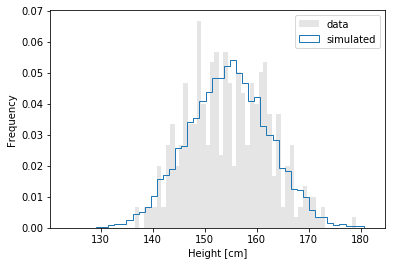

In [9]:
sim = ss.norm.rvs(loc=sample_grid['mu'], scale=sample_grid['s'])
plt.hist(h, bins=50, density=True, color='grey', alpha=0.2, label='data')
plt.hist(sim, bins=50, density=True, histtype='step', label='simulated')
plt.legend()
plt.xlabel('Height [cm]')
plt.ylabel('Frequency');